# Water body Image Level Detection Model · From Single Fixed Camera History

---

In [1]:
cd ../

C:\Users\luisr\Desktop\Repositories\Data Science Projects\Hackaton COR IV - Centro de Operações do RJ\INCUBAÇÃO\Cameras


#### General purpose parameters

In [2]:
random_state = 0 # seed for random generator
replacement = False

#### Import libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import classification_report
from imblearn.under_sampling import RandomUnderSampler

sns.set()  # set default Seaborn plot styles

---
## Define python utility classes and methods

#### Function to relabel target variable class labels

In [4]:
def relabel(Y: pd.Series, labels: dict) -> pd.Series:
    """
    Relabels the given Pandas series with the corresponding label from the given dictionary.

    Parameters:
    Y (pd.Series): Pandas series to relabel
    labels (dict): Dictionary containing the corresponding labels for each tag

    Returns:
    pd.Series: Relabeled Pandas series
    """
    y_true = []
    for tag in Y:
        for key, values in labels.items():
            if tag in values:
                y_true.append(key)
                break
    return pd.Series(y_true, index=Y.index)

#### Function to display train and test classes counting

In [5]:
import pandas as pd

def split_class_count(y_train, y_test):
    """
    Prints the count of unique values in the y_train and y_test pandas series.

    Args:
    - y_train: pandas series of the training set.
    - y_test: pandas series of the test set.
    """
    display(pd.concat([
        pd.Series(y_train).value_counts().to_frame('Train set'),
        pd.Series(y_test).value_counts().to_frame('Test set')
    ], axis=1))


#### Class to measure execution time

In [6]:
class Timer:
    """
    Class to measure the execution time of code.
    """

    def __init__(self):
        """
        Initializes the Timer class by setting the start time.
        """
        self.start = time()

    def end(self, decimals=4) -> float:
        """
        Calculates, prints and returns the execution time.

        Parameters:
        decimals (int): Number of decimals to round the execution time.

        Returns:
        float: Execution time in seconds.
        """
        end = time() - self.start
        print(f"\n* TIME TO EXECUTE: {round(end, decimals)} s")
        return round(end, decimals)

#### Class to load frames from labeled videos as labeled images

In [7]:
import os, cv2, numpy as np
from IPython.display import clear_output as co

class FrameLoader:
        
    def __init__(self, dim=3):
        """  """
        self.dim = dim
        
    def frames_from_labeled_videos(self, paths, labels, print_each=None):
        i, n  = 0, max(len(paths), len(labels))
        x, y = [], []
        for path, label in zip(paths, labels):
            frames = self.frames_from_video(path)
            x += frames;
            y += [label] * len(frames)
            i += 1
            if print_each is not None and i % print_each == 0:
                co(True); print(f'CAPTURE LABELED VIDEOS · OPEN: {i}/{n}')
        return np.array(x), np.array(y)
        
    def frames_from_video(self, path):
        cap = cv2.VideoCapture(path)
        if not cap.isOpened():
            print(f"CANNOT OPEN VIDEO CAPTURE · PATH: {path}")
            return []
        frames = []
        while True:
            ret, frame = cap.read()
            if not ret:
                break # stream finished
            if self.dim == 1: # 1D flat frame from 2D gray scale frame
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                frame = np.reshape(frame, -1)
            if self.dim == 2: # 2D gray scale frame
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            frames.append(frame)
        cap.release(); cv2.destroyAllWindows()
        return frames

#### Class to wrap regression models with rounded prediction functionality

In [8]:
import numpy as np

bins_default = bins = np.array([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])

def round_close(Y, bins=bins_default):
    Y_round = []
    for value in Y:
        diffs = np.abs(bins - value)
        rounded_value = bins[diffs==diffs.min()][0]
        Y_round.append(rounded_value)
    return np.array(Y_round)

class RounderRegressor:
    
    def __init__(self, model=None, fitted_model=None, bins=bins_default):
        self.model = model
        self.fitted_model = fitted_model
        self.bins = bins
        
    def fit(self, x, y):
        self.fitted_model = self.model.fit(x, y)
        return self
    
    def predict(self, x):
        y_pred = self.fitted_model.predict(x)
        y_pred_round = round_close(y_pred, self.bins)
        return y_pred_round

#### Function to display mislabeled images

In [9]:
import numpy as np
import matplotlib.pyplot as plt

def display_mislabeled_images(X_test, y_test, y_pred, display_max=5, random=True, img_shape=(854, 480), n_cols=3):

    error_msk = y_test != y_pred
    n_mis = error_msk.sum()

    x_test_mis = X_test[error_msk]
    y_test_mis = y_test[error_msk]
    y_pred_mis = y_pred[error_msk]

    n_imgs = min(n_mis, display_max)

    index_show = list(range(n_imgs))
    if random:
        index_show = np.random.choice(index_show, size=n_imgs, replace=False)

    mis_samples = x_test_mis[index_show]
    mis_labels = y_test_mis.iloc[index_show]
    mis_preds = y_pred_mis[index_show]

    n_rows = n_imgs // n_cols + 1
    fig = plt.figure(figsize=(6 * n_cols, 4.5 * n_rows))
    axs = [fig.add_subplot(n_rows, n_cols, i) for i in range(1, n_imgs + 1)]

    for i, (xi, yi, ypi, tstamp) in enumerate(zip(mis_samples, mis_labels, mis_preds, mis_labels.index)):
        ax = axs[i]
        img_reshape = np.reshape(xi, tuple(reversed(img_shape)))
        ax.imshow(img_reshape)
        ax.set(title=f'{tstamp} · True: {yi} · Predicted: {ypi}')
        ax.grid(False)
        
    plt.show()

---
## Choose and define camera `code` variable

In [10]:
code = 1487

---
## Reload labeled videos dataset

In [11]:
import pandas as pd

videos = pd.read_csv(f'Dados/Rotulados/videos_labeled_CODE{code}_2023-04-29.csv')

# preprocessing
videos['timestamp'] = pd.to_datetime(videos['timestamp'])
# videos = videos.sort_values('timestamp')

# drop videos larger than `video_max_bytes`
max_video_bytes = 5e6 # 5 Mb
# videos = videos[videos['blob_size'] < max_video_bytes]

display(videos[['blob_name', 'tag']].head())
print(f'Shape: {videos.shape}')

mega_bytes = round(videos["blob_size"].sum() / 1e6, 3)
print(f'\nTotal bytes of video: {mega_bytes} Mb')

,blob_name,tag
0,polygons/flood-unlabeled/-1/1487/CODE1487 2023...,0.2
1,polygons/flood-unlabeled/-1/1487/CODE1487 2023...,0.2
2,polygons/flood-unlabeled/-1/1487/CODE1487 2023...,0.2
3,polygons/flood-unlabeled/-1/1487/CODE1487 2023...,1.0
4,polygons/flood-unlabeled/-1/1487/CODE1487 2023...,1.0


Shape: (360, 9)

Total bytes of video: 338.954 Mb


---
## Reload labeled images dataset

In [12]:
import pandas as pd

# code = 1648 # 1487
image_max_bytes = 5e6 # 5 Mb

images = pd.read_csv(f'Dados/Rotulados/images_labeled_CODE{code}_2023-04-29.csv')

# preprocessing
images['timestamp'] = pd.to_datetime(images['image_timestamp'])
images = images.set_index('image_timestamp', drop=True).sort_index()

# drop images larger than `video_max_bytes`
# image_max_bytes = 5e6 # 5 Mb
# images = images[images['blob_size'] < image_max_bytes]

display(images[['blob_name', 'tag']].head())
print(f'Shape: {images.shape}')

# mega_bytes = round(images["blob_size"].sum() / 1e6, 3)
# print(f'\nTotal video bytes: {mega_bytes} Mb')

,blob_name,tag
image_timestamp,,
2023-02-07 19:25:00.000,polygons/flood-unlabeled/-1/1487/CODE1487 2023...,0.2
2023-02-07 19:25:00.333,polygons/flood-unlabeled/-1/1487/CODE1487 2023...,0.2
2023-02-07 19:25:00.667,polygons/flood-unlabeled/-1/1487/CODE1487 2023...,0.2
2023-02-07 19:25:01.000,polygons/flood-unlabeled/-1/1487/CODE1487 2023...,0.2
2023-02-07 19:25:01.333,polygons/flood-unlabeled/-1/1487/CODE1487 2023...,0.2


Shape: (11354, 9)


---
## Optional · Image Data Preprocessing

#### Optional · Relabel images

In [13]:
replace_tags = {
    0: [0.0],
    1: [0.2],
    2: [0.4],
    3: [0.6],
    4: [0.8],
    5: [1.0],
}

images['label'] = relabel(images['tag'], replace_tags)

display(images['tag'].value_counts().to_frame('Images Tags'))
display(images['label'].value_counts().to_frame('Images Encoded Labels'))

,Images Tags
0.0,7310
0.2,2542
0.4,585
0.6,495
1.0,227
0.8,195


,Images Encoded Labels
0,7310
1,2542
2,585
3,495
5,227
4,195


#### Maximum video label from images' labels

In [14]:
# Calculate the maximum label for each blob name in the images DataFrame
video_labels_from_images = images.groupby('blob_name')['label'].max()

# Calculate the percentage of videos in the videos DataFrame that have a corresponding blob name in the images DataFrame
percentage_videos_in_images = videos['blob_name'].isin(video_labels_from_images.index).mean().round(4) * 100

# Print the percentages
print('`Videos` in `Images` Videos:', percentage_videos_in_images, '%')
print('`Images` Videos in `Videos`:', video_labels_from_images.index.isin(videos['blob_name']).mean().round(4) * 100, '%')

`Videos` in `Images` Videos: 75.56 %
`Images` Videos in `Videos`: 100.0 %


---
## Optional · Video Data Preprocessing

#### Optional · Binarize videos class labels

In [15]:
replace_tags = {
    0: [0.0],
    1: [0.2],
    2: [0.4],
    3: [0.6],
    4: [0.8],
    5: [1.0],
}

videos['label'] = relabel(videos['tag'], replace_tags)

display(videos['tag'].value_counts().to_frame('Video Tags').sort_index())
display(videos['label'].value_counts().to_frame('Encoded Video Labels').sort_index())

,Video Tags
0.0,276
0.2,70
0.4,3
0.6,6
1.0,5


,Encoded Video Labels
0,276
1,70
2,3
3,6
5,5


#### Percentual difference in videos labels and labels from images

In [16]:
# Retrieve labels of videos and compare them to labels of images
videos_labels = videos.set_index('blob_name', drop=True).loc[video_labels_from_images.index]['label']

# Calculate the mean of the equality comparison between the labels
mean_label_equality = (videos_labels == video_labels_from_images).mean()

print(mean_label_equality)

1.0


#### Drop videos without labeled images

In [17]:
# Map video labels from images' labels
video_labels_updated = videos['blob_name'].map(video_labels_from_images)

# Create a mask for non-NaN values
not_na_msk = ~video_labels_updated.isna()

# Filter videos with non-NaN labels
videos = videos[not_na_msk].reset_index(drop=True)

#### Adjust video labels with labels from images

In [18]:
# Update the 'label' column for non-NaN values
videos['label'] = video_labels_updated.dropna()

# Display the value counts for the 'label' column after the update
display(videos['label'].value_counts().to_frame('Updated Video Labels').sort_index())

,Updated Video Labels
0.0,188
1.0,70
2.0,3
3.0,6
5.0,5


---
## Optional · Video Data Sampling

#### Optional · Under sampling videos from majority class · Drop exceeding class members

In [19]:
from imblearn.under_sampling import RandomUnderSampler

# sampling_strategy = 'auto'

sampling_strategy = {
    0.0: 25,
    1.0: 25,
    2.0: 3,
    3.0: 6,
    # 4.0: 5,
    5.0: 5,
}

# Sampler instance
rus = RandomUnderSampler(
    sampling_strategy=sampling_strategy,
    random_state=random_state,
    replacement=replacement
)

# Resample operation
x_res, y_res = rus.fit_resample(videos, videos['label'])

display(y_res.value_counts().to_frame('Videos Sub-sample').sort_index())

,Videos Sub-sample
0.0,25
1.0,25
2.0,3
3.0,6
5.0,5


#### Optional · Train and test split of video samples

In [ ]:
from sklearn.model_selection import train_test_split

t_size = 0.5  # 0.25 recommended after under-sample
e_size = 0.5  # 0.25 recommended after under-sample

# True class labels
# y_true = videos['tag']

X, Y = x_res, y_res  # pre-sampled
# X, Y = videos, y_true  # complete set of videos

xt, xe, yt, ye = train_test_split(
    X, Y, test_size=e_size, train_size=t_size,
    random_state=random_state, shuffle=True,
    stratify=Y
)

# complete x and y sequences
yy = pd.concat([yt, ye], axis=0)
xx = pd.concat([xt, xe], axis=0)

split_class_count(yt, ye)
display(yy.value_counts().to_frame('Video Samples'))

---
## Load images and class labels from selected labeled videos

In [21]:
folder = 'Dados/flood-video-collection'
LABEL_TYPE = 'IMAGE_LABEL'

XX, YY = x_res, y_res  # pre-sampled from loaded videos dataset
# XX, YY = xx, yy  # pre-sampled from loaded videos dataset
# XX, YY = videos, y_true  # complete set of frames from loaded videos dataset
# XX, YY = video_label.reset_index(), video_label

replace_tags = {
    0: [0.0],
    1: [0.2],
    2: [0.4],
    3: [0.6],
    4: [0.8],
    5: [1.0],
}

videos_paths = [f'{folder}/{blob_name}'.replace(':', '-') for blob_name in XX['blob_name']]
videos_labels = YY.tolist()

video_loader = FrameLoader(dim=1)
frames, labels = video_loader.frames_from_labeled_videos(videos_paths, videos_labels, print_each=1)

if LABEL_TYPE == 'IMAGE_LABEL':
    frames_metadata = pd.concat([images[images['blob_name']==blob_name].sort_values('image_timestamp') for blob_name in  XX['blob_name']])
    labels = frames_metadata['tag']
    labels = relabel(labels, replace_tags)
    frames = pd.DataFrame(frames, index=labels.index)
    
print(f'\nVideos Selected: {len(XX)}')
print(f'Frames Loaded: {len(frames)}')
print(f'Frame shape: {frames[0].shape}')
print()

display(pd.Series(labels).value_counts().to_frame('Image Samples'))

CAPTURE LABELED VIDEOS · OPEN: 64/64

Videos Selected: 64
Frames Loaded: 3424
Frame shape: (3424,)



,Image Samples
0,983
1,939
2,585
3,495
5,227
4,195


---
## Image Data Sampling

#### Under sampling images from majority class · Drop exceeding class members

In [32]:
from imblearn.under_sampling import RandomUnderSampler

sampling_strategy = 'auto'

rus = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=random_state, replacement=replacement)

X_res, Y_res = rus.fit_resample(frames, labels)
Y_res = pd.Series(Y_res)

display(Y_res.value_counts().to_frame('Images Under-Sampled'))

,Images Under-Sampled
0,195
1,195
2,195
3,195
4,195
5,195


#### Clear memory after sampling

In [33]:
frames = None  # clear memory

---
## Scaling numerical target variable

In [34]:
# SCALE TARGET VARIABLE IN BETWEEN 0.0 AND 1.0

if Y_res.max() != 1.0:
    print('LABELS RESAMPLED')
    Y_res = Y_res / 5

display(Y_res.value_counts().to_frame('Image Labels Scaled'))

LABELS RESAMPLED


,Image Labels Scaled
0.0,195
0.2,195
0.4,195
0.6,195
0.8,195
1.0,195


---
## Image Classification Model Evaluation

#### Train and test split of image samples

In [61]:
t_size = 0.125
e_size = 0.5

X_train, X_test, y_train, y_test = train_test_split(
    X_res, Y_res, train_size=t_size, test_size=e_size,
    random_state=random_state, shuffle=True,
    stratify=Y_res
    # stratify=labels
)

split_class_count(y_train, y_test)

,Train set,Test set
1.0,30,97
0.6,29,98
0.2,29,98
0.0,29,97
0.8,29,98
0.4,29,97


#### Clear memory

In [171]:
# X_res, Y_res = None, None  # clear memory

#### Fit and predict image classifier base model

In [36]:
# Import necessary modules
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (
    mean_absolute_error as mae,
    mean_absolute_percentage_error as mape,
    mean_squared_error as mse,
)

# Create linear regression model
model = lr = LinearRegression()

# Start timer
timer = Timer()

# Fit model
model.fit(X_train, y_train)
timer.end()

# Make prediction
y_pred = model.predict(X_test)
timer.end()


* TIME TO EXECUTE: 28.2107 s

* TIME TO EXECUTE: 38.3692 s


#### Evaluate base model prediction

In [38]:
print("Mean Absolute Diff.:",  round(mae(y_test, y_pred) * 100, 2), '%')
print("Mean Absolute Prct. Diff.:",  round(mape(y_pred, y_test) * 100, 2), '%')
print("Mean Squared Diff.:",  round(mse(y_test, y_pred), 2))

Mean Absolute Diff.: 3.6 %
Mean Absolute Prct. Diff.: 23.9 %
Mean Squared Diff.: 0.0


#### Round prediction by closest value

In [43]:
bins = np.array([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])

y_pred_round = round_close(y_pred, bins)

#### Evaluate base model rounded prediction

In [46]:
print("Number of mislabeled points out of total of %d points : %d\n"
      % (X_test.shape[0], (y_test != y_pred_round).sum()))

print("Mean Absolute Diff.:",  round(mae(y_test, y_pred_round) * 100, 2), '%')
print("Mean Absolute Prct. Diff.:",  round(mape(y_test, y_pred_round) * 100, 2), '%')
print("Mean Squared Diff.:",  round(mse(y_test, y_pred_round), 2))

Number of mislabeled points out of total of 585 points : 44

Mean Absolute Diff.: 1.5 %
Mean Absolute Prct. Diff.: 307938436059524.06 %
Mean Squared Diff.: 0.0


#### Rounded prediction classification report

In [47]:
from sklearn.metrics import classification_report

print(classification_report(y_test * 5, y_pred_round * 5))

              precision    recall  f1-score   support

         0.0       0.99      0.98      0.98        98
         1.0       0.92      0.93      0.92        97
         2.0       0.85      0.94      0.89        97
         3.0       0.97      0.90      0.93        98
         4.0       0.86      0.97      0.91        98
         5.0       1.00      0.84      0.91        97

    accuracy                           0.92       585
   macro avg       0.93      0.92      0.93       585
weighted avg       0.93      0.92      0.93       585



#### Rounded prediction evaluation per class

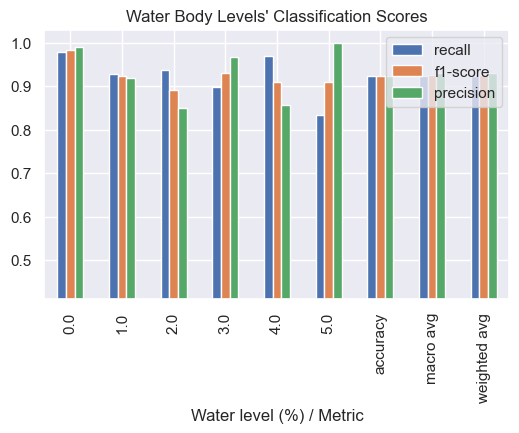

In [48]:
cr = classification_report(y_test * 5, y_pred_round * 5, output_dict=True)

cr = pd.DataFrame(cr)

ax = cr.T[['recall', 'f1-score', 'precision']].plot.bar(figsize=(6, 3.5))
ax.set(
    title="Water Body Levels' Classification Scores",
    xlabel='Water level (%) / Metric',
    ylim=(0.41, 1.03)
)
plt.show()

#### Prediction error distribution

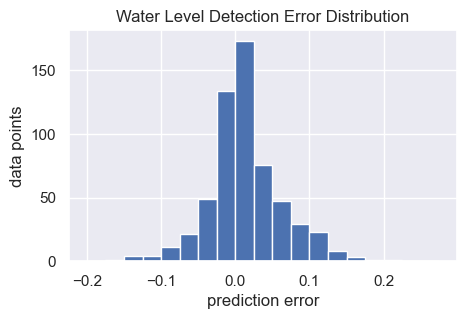

In [49]:
bin_interval = 0.025

fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot()

pred_diff = y_test - y_pred

# adjusted bins for histogram
bins_min = round(min(pred_diff) - 0.05, 1)
bins_max = round(max(pred_diff) + 0.05, 1)
bins = np.arange(bins_min, bins_max, bin_interval)

pred_diff.hist(ax=ax, bins=bins)


ax.set(
    xlabel='prediction error',
    ylabel='data points',
    title='Water Level Detection Error Distribution')
plt.show()

#### Rounded prediction error distribution

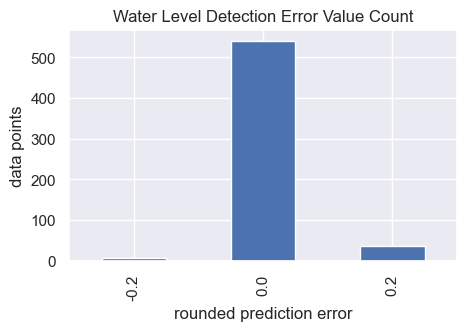

In [50]:
decimals = 1

pred_diff_round = (y_test - y_pred_round).round(decimals)

fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot()

pred_diff_round.value_counts().sort_index().plot.bar(ax=ax, figsize=(5, 3))

ax.set(
    xlabel='rounded prediction error',
    ylabel='data points',
    title='Water Level Detection Error Value Count')
plt.show()

### Save base model for camera code 

In [53]:
import pickle
from datetime import datetime as dt 
from sklearn.pipeline import Pipeline

# Code value
# code = 1487

# Get current date as string
date = dt.now().date().isoformat()

# Set file name for the saved model
file_name = f'models/water-level/code{code}_{date}.sav'

# Get the final model
final_bins = np.arange(0.00, 1.05, 0.05)
final_model = Pipeline([('LR', RounderRegressor(fitted_model=model, bins=final_bins))])

# Save the model to disk
with open(file_name, 'wb') as model_file:
    pickle.dump(final_model, model_file)
    
# Print result
print(f'\n * Moder saved to: {file_name}\n')
display(final_model)


 * Moder saved to: models/water-level/code1487_2023-05-06.sav



Pipeline(steps=[('LR',
                 <__main__.RounderRegressor object at 0x000001AD4AB876D0>)])

#### Display random sample of mislabeled images

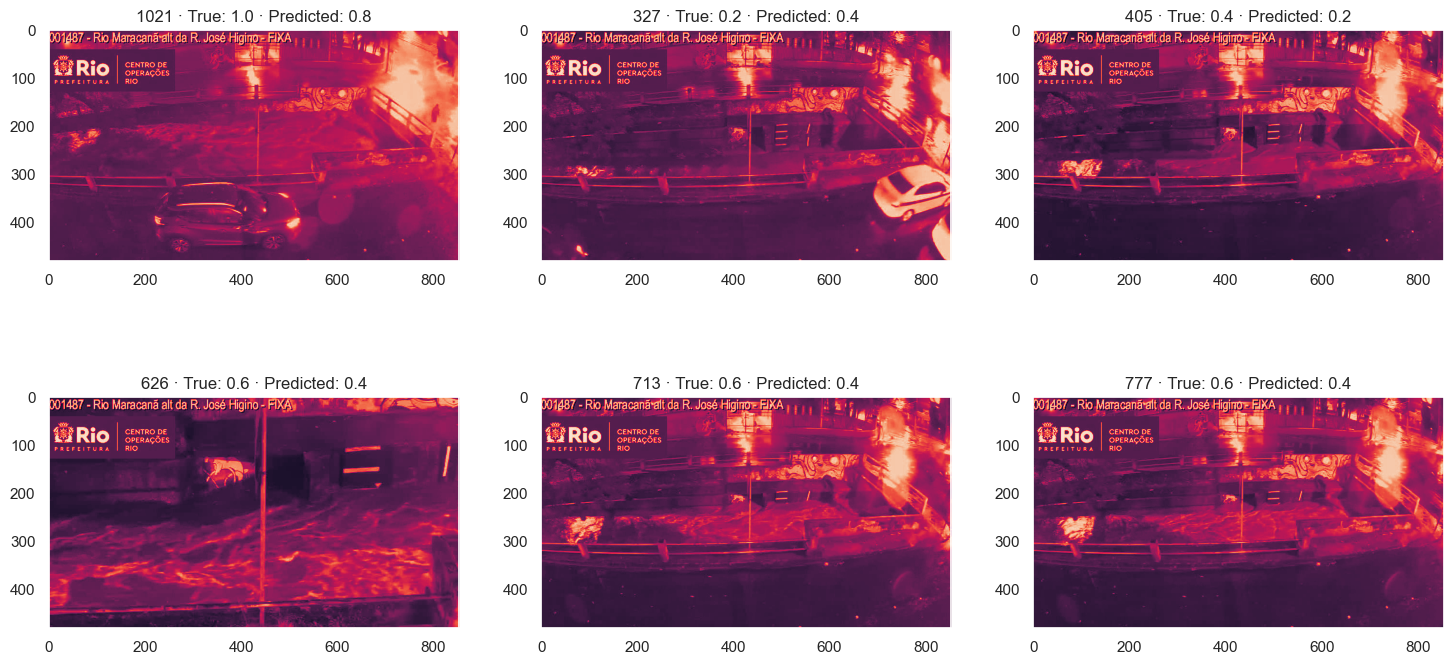

In [54]:
n_cols = 3
display_max = 6
random = True

display_mislabeled_images(X_test.values, y_test, y_pred_round, display_max, random, n_cols=n_cols)

---
## Learning Curve Analysis

#### Train test split image samples

In [62]:
t_size = 0.20 # 0.1
e_size = 0.50 # 0.4

X_train, X_test, y_train, y_test = train_test_split(
    X_res, Y_res, train_size=t_size, test_size=e_size,
    random_state=random_state, shuffle=True, stratify=Y_res
)

split_class_count(y_train, y_test)

,Train set,Test set
1.0,39,98
0.0,39,97
0.2,39,98
0.6,39,97
0.8,39,97
0.4,39,98


#### Fit regression model with rounded predictions using sklearn's `Pipeline` · EXECUTION TIME

In [63]:
from sklearn.pipeline import Pipeline

# Obs: Use sklearn's pipeline, so sklearn's `learning_curve` method interprets model as a sklearn estimator

# Create a pipeline for a image model
pipe = Pipeline(steps=[('RounderRegressor', RounderRegressor(LinearRegression()))])

# Create a timer object
timer = Timer()

# Fit the pipeline to the training data
pipe.fit(X_train, y_train)

# End the timer
timer.end()


* TIME TO EXECUTE: 29.7869 s


#### Predict with rounded regressor pipeline · EXECUTION TIME

In [64]:
# Create a timer object
timer = Timer()

# Predict the first 5 values using the trained model
pipe.predict(X_test)

# End the timer
timer.end()


* TIME TO EXECUTE: 14.2164 s


#### Learning curve · Increase train size iteratively

In [65]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import learning_curve


model = pipe

# indices for train and test datasets
cv = [[y_train.index, y_test.index]]

# fractions of the dataset to be used as training data
train_sizes = np.arange(0.2, 1.1, 0.2)

# scoring metrics to evaluate model performance
scoring = [
    'neg_mean_absolute_error',
    'neg_mean_absolute_percentage_error',
    'neg_mean_squared_error',
]

# learning curve of the model
curve = learning_curve(
    model, X_res, Y_res,
    groups=Y_res, cv=cv,
    train_sizes=train_sizes,
    scoring=scoring[0],
    return_times=True,
    shuffle=True,
    random_state=random_state,
    verbose=1, # n_jobs=2,
)

[learning_curve] Training set sizes: [ 46  93 140 187 234]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  3.6min finished


#### Learning Curve Plots

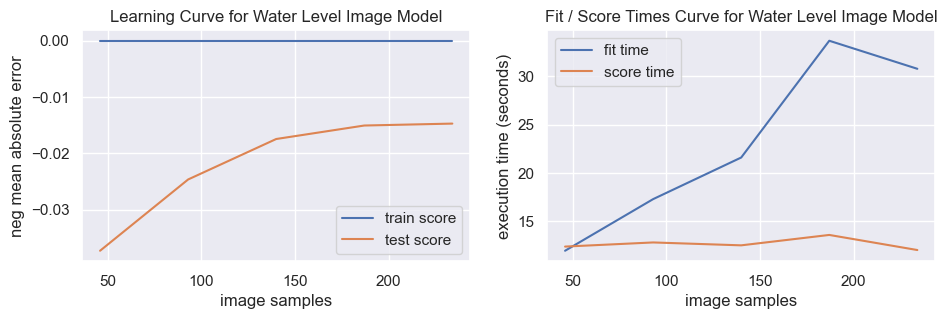

In [66]:
fig, ax = plt.subplots(1, 2, figsize=(11, 3))

# Learning Curve Plot
ax[0].plot(curve[0], curve[1], label='Train Set')
ax[0].plot(curve[0], curve[2], label='Test Set')
ax[0].legend(['train score', 'test score'])
ax[0].set(
    title=f'Learning Curve for Water Level Image Model',
    xlabel='image samples', ylabel=' '.join(scoring[0].split('_')),
)

# Fit and Score Times' Curve Plot
ax[1].plot(curve[0], curve[3], label='Train Set')
ax[1].plot(curve[0], curve[4], label='Test Set')
ax[1].legend(['fit time', 'score time'])
ax[1].set(
    title=f'Fit / Score Time Curve for Water Level Image Model',
    xlabel='image samples', ylabel='execution time (seconds)',
)

plt.show()